<a href="https://colab.research.google.com/github/samuelhurni/ML-Cellsegmentation-HSLU-FS24/blob/feature_Dev/ML_Project_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports
import os
import cv2
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim


In [2]:
#drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
train_path= '/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/train'
csv_path='/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/train.csv'
#test_path= '/content/drive/"My Drive"/name_of_dataset_folder'
# os.chdir('/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation')

_, _, files = next(os.walk(train_path))
file_count = len(files)

annotations = pd.read_csv(csv_path)

height = annotations['height'][0]
width =  annotations['width'][0]

sample_ids = annotations['id'].unique()

print(len(sample_ids))
print(len(annotations))
print(file_count)
print(height)
print(width)

606
73585
606
520
704


In [4]:
from PIL import Image

def decode_rle(rle_string, height, width):
    rle_numbers = list(map(int, rle_string.split()))
    mask = np.zeros(height * width, dtype=np.uint8)

    for start, length in zip(rle_numbers[0::2], rle_numbers[1::2]):
        start -= 1  # Convert to zero-indexed
        mask[start:start + length] = 1

    return mask.reshape((height, width))

data_dict = {}

ids = []
masks = []

for id in sample_ids:
  id_df = annotations[annotations['id'] == id]
  id_annotations = id_df['annotation']
  all_masks = []
  for annot in id_annotations:
    mask = decode_rle(annot, height, width)
    all_masks.append(mask)
  resultant_mask = all_masks[0]

  for mask in all_masks[1:]:
    resultant_mask = np.bitwise_or(resultant_mask, mask)

  ids.append(id)
  masks.append(resultant_mask)

data_dict['id'] = ids
data_dict['annotation'] = masks

annotations = pd.DataFrame(data_dict)

print(annotations.head())
print(len(annotations))


             id                                         annotation
0  0030fd0e6378  [[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
1  0140b3c8f445  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
2  01ae5a43a2ab  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  026b3c2c4b32  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  029e5b3b89c7  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
606


(520, 704)
(704, 520)


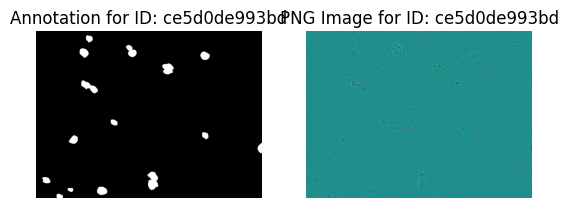

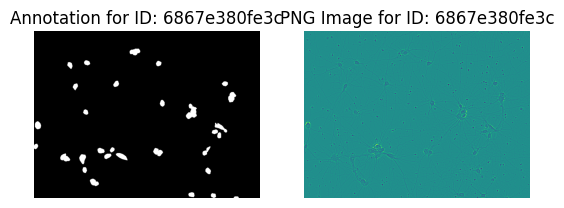

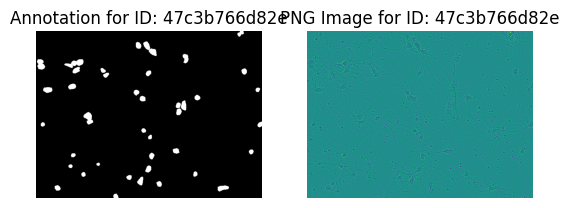

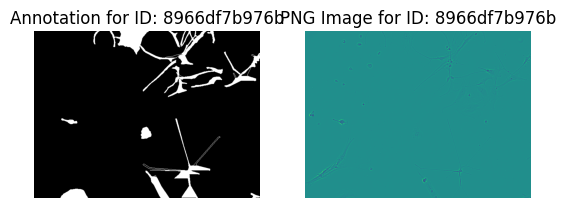

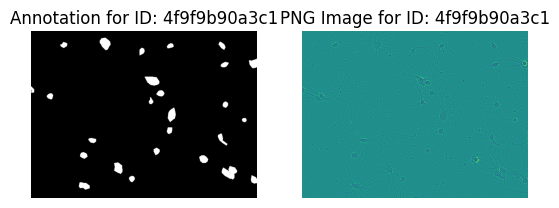

In [5]:
random_rows = annotations.sample(n=5)

print(annotations['annotation'][0].shape)
img = Image.open(train_path + '/' + annotations['id'][0] + '.png')
print(img.size)

# Iterate over the selected random rows
for index, row in random_rows.iterrows():
    plt.subplot(1, 2, 1)
    plt.imshow(row['annotation'], cmap='gray')
    plt.title('Annotation for ID: ' + row['id'])
    plt.axis('off')

    # Load and display the corresponding PNG image based on the ID
    plt.subplot(1, 2, 2)
    img = Image.open(train_path + '/' + row['id'] + '.png')
    plt.imshow(img)
    plt.title('PNG Image for ID: ' + row['id'])
    plt.axis('off')

    plt.show()

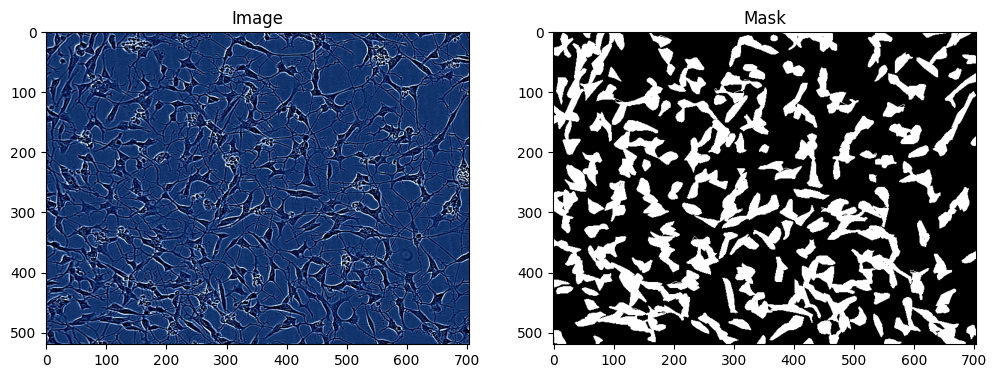

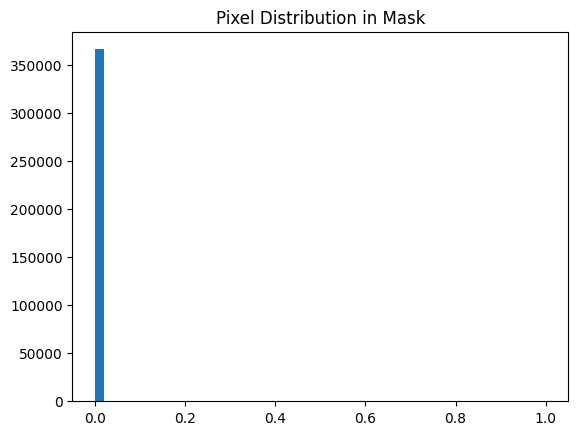

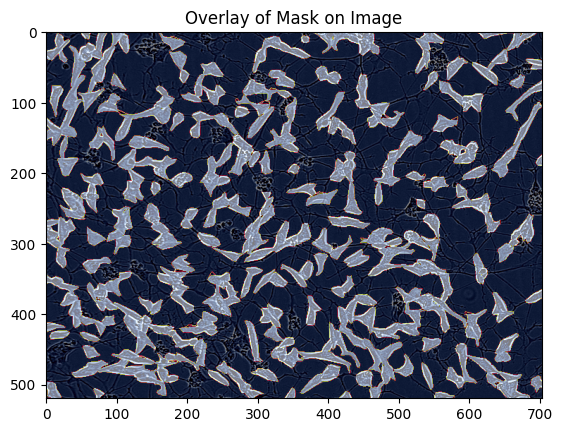

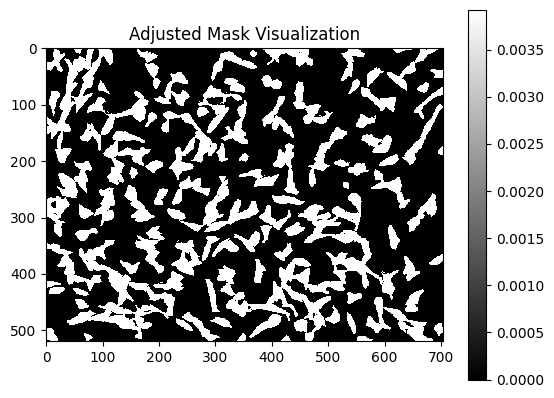

In [6]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import os


from torchvision.transforms.functional import to_pil_image, to_tensor, hflip, vflip

class RandomHorizontalVerticalFlip:
    """Apply horizontal or vertical flip randomly to both image and mask."""
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if torch.rand(1) < self.p:
            image = hflip(image)
            mask = hflip(mask)
        if torch.rand(1) < self.p:
            image = vflip(image)
            mask = vflip(mask)
        return image, mask

# Define the complete transformation for images and masks
def transform(image, mask):
    # Convert numpy image and mask to PIL for compatibility with torchvision transforms
    image = to_pil_image(image)
    mask = to_pil_image(mask)

    transform = RandomHorizontalVerticalFlip(p=0.5)
    image, mask = transform(image, mask)

    image = to_tensor(image)
    mask = to_tensor(mask)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = normalize(image)

    return image, mask


class SartoriusDataset(Dataset):
    def __init__(self, annotations, img_dir, transform=None):
        self.annotations = annotations  # Assume annotations is already a DataFrame
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_id = self.annotations['id'][idx]

        img_path = os.path.join(self.img_dir, f'{img_id}.png')
        image = cv2.imread(img_path)

        if image is None:
            raise FileNotFoundError(f"No image found at {img_path}")

        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = self.annotations['annotation'][idx]

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask


# Assuming 'annotations' is your DataFrame and 'train_path' is the directory where your images are stored


dataset = SartoriusDataset(annotations, train_path, transform=transform)

image, mask = dataset[0]  # Get the first sample

# Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# Assuming `image` is a PyTorch tensor with shape (3, height, width)
# Convert it to a numpy array and transpose it to (height, width, 3) for visualization
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # Rearrange dimensions
elif isinstance(image, np.ndarray):
    if image.ndim == 3 and image.shape[0] == 3:  # If it's in CHW format
        image = np.transpose(image, (1, 2, 0))  # Change to HWC for imshow

# Now use plt.imshow() to display the image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

# Assuming `mask` is also a tensor and needs to be squeezed if it has a channel dimension
if isinstance(mask, torch.Tensor):
    mask = mask.squeeze().numpy()  # Remove channel dimension if it exists
elif isinstance(mask, np.ndarray) and mask.ndim == 3:
    mask = mask.squeeze()  # Squeeze to remove single-channel dimension for grayscale

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask')
plt.show()

import matplotlib.pyplot as plt

# Example usage with a single RLE string and its corresponding size
example_rle = "10 5"  # This is a dummy example; replace it with an actual RLE from your dataset
shape = (100, 100)    # Replace with actual dimensions of the image



plt.hist(mask.ravel(), bins=50, range=[0,1])
plt.title('Pixel Distribution in Mask')
plt.show()

plt.imshow(image, cmap='gray')  # assuming image is grayscale
plt.imshow(mask, cmap='hot', alpha=0.5)  # overlay mask
plt.title('Overlay of Mask on Image')
plt.show()

plt.imshow(mask, cmap='gray', interpolation='none')
plt.colorbar()
plt.title('Adjusted Mask Visualization')
plt.show()



In [7]:
import torch
import torch.nn as nn

class SmallUNet(nn.Module):
    def __init__(self):
        super(SmallUNet, self).__init__()

        # Define encoder (downsampling) path
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2)
        )

        # Define decoder (upsampling) path
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Define output layer
        self.output = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        # Forward pass through encoder
        x1 = self.encoder(x)

        # Forward pass through decoder
        x = self.decoder(x1)

        # Output layer
        x = self.output(x)

        return x


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

learning_rate = 0.01

total_size = len(dataset)
val_size = int(0.1 * total_size)  # 10% for validation
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Assuming you have already split your dataset into training and validation
total_size = len(dataset)  # Total number of images in the dataset
train_size = len(train_dataset)  # Number of training data samples
val_size = len(val_dataset)  # Number of validation data samples

print(f"Total number of data samples: {total_size}")
print(f"Number of training samples: {train_size}")
print(f"Number of validation samples: {val_size}")


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Check the number of batches in the DataLoader and the number of samples per batch
num_batches = len(train_loader)
print(f"Number of batches in the training DataLoader: {num_batches}")


Using device: cuda
Total number of data samples: 606
Number of training samples: 546
Number of validation samples: 60
Number of batches in the training DataLoader: 137


In [9]:

# Instantiate the U-Net model and move it to the appropriate device
model = SmallUNet().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model_dir = '/content/drive/MyDrive/ML_Project'
model_path = os.path.join(model_dir, 'model.pth')

num_epochs = 50

# Lists to store training and validation loss
train_loss_history = []
val_loss_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0

    pbar = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    # Training phase
    for images, masks in pbar:
        # Move data to the appropriate device
        images, masks = images.to(device), masks.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(train_loss)

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for val_images, val_masks in val_loader:
            # Move data to the appropriate device
            val_images, val_masks = val_images.to(device), val_masks.to(device)

            # Forward pass
            val_outputs = model(val_images)

            # Calculate validation loss
            val_loss = criterion(val_outputs, val_masks)

            # Accumulate validation loss
            running_val_loss += val_loss.item()

    # Calculate average validation loss for the epoch
    val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss}, Validation Loss: {val_loss}")
    if val_loss == min(val_loss_history):
        torch.save(model.state_dict(), model_path)
        print("Saved Best Model")

print("Finished Training")


Epoch 1/50: 100%|██████████| 137/137 [00:35<00:00,  3.89it/s]


Epoch [1/50], Training Loss: 0.015053229006245243, Validation Loss: 0.0036814578187962374
Saved Best Model


Epoch 2/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [2/50], Training Loss: 0.0036847180968157295, Validation Loss: 0.0035521209938451648
Saved Best Model


Epoch 3/50: 100%|██████████| 137/137 [00:35<00:00,  3.87it/s]


Epoch [3/50], Training Loss: 0.0034146071288455957, Validation Loss: 0.003473247281120469
Saved Best Model


Epoch 4/50: 100%|██████████| 137/137 [00:34<00:00,  3.92it/s]


Epoch [4/50], Training Loss: 0.0035627752595180032, Validation Loss: 0.003539584142466386


Epoch 5/50: 100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch [5/50], Training Loss: 0.003527211333815362, Validation Loss: 0.0035058600013144316


Epoch 6/50: 100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch [6/50], Training Loss: 0.003416353143262167, Validation Loss: 0.003445319222131123
Saved Best Model


Epoch 7/50: 100%|██████████| 137/137 [00:34<00:00,  3.93it/s]


Epoch [7/50], Training Loss: 0.0033787455261909288, Validation Loss: 0.0033832565299235285
Saved Best Model


Epoch 8/50: 100%|██████████| 137/137 [00:34<00:00,  3.99it/s]


Epoch [8/50], Training Loss: 0.0034424410242821857, Validation Loss: 0.003498785108483086


Epoch 9/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [9/50], Training Loss: 0.003341207640197971, Validation Loss: 0.003357412526383996
Saved Best Model


Epoch 10/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [10/50], Training Loss: 0.003314007933159787, Validation Loss: 0.003342673865457376
Saved Best Model


Epoch 11/50: 100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch [11/50], Training Loss: 0.003274370651491612, Validation Loss: 0.003300230682361871
Saved Best Model


Epoch 12/50: 100%|██████████| 137/137 [00:35<00:00,  3.90it/s]


Epoch [12/50], Training Loss: 0.0033318113833478904, Validation Loss: 0.0033553378462481


Epoch 13/50: 100%|██████████| 137/137 [00:34<00:00,  3.93it/s]


Epoch [13/50], Training Loss: 0.0032280650717226695, Validation Loss: 0.003339830196152131


Epoch 14/50: 100%|██████████| 137/137 [00:34<00:00,  3.93it/s]


Epoch [14/50], Training Loss: 0.0032683671076092053, Validation Loss: 0.0033168020270143944


Epoch 15/50: 100%|██████████| 137/137 [00:34<00:00,  3.92it/s]


Epoch [15/50], Training Loss: 0.0032556336107544847, Validation Loss: 0.003339790677030881


Epoch 16/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [16/50], Training Loss: 0.003269913042113729, Validation Loss: 0.003337546829910328


Epoch 17/50: 100%|██████████| 137/137 [00:35<00:00,  3.90it/s]


Epoch [17/50], Training Loss: 0.0032444907795046423, Validation Loss: 0.0033034460269846023


Epoch 18/50: 100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch [18/50], Training Loss: 0.003234372861312879, Validation Loss: 0.0032285626822461683
Saved Best Model


Epoch 19/50: 100%|██████████| 137/137 [00:34<00:00,  3.92it/s]


Epoch [19/50], Training Loss: 0.0032409487056790642, Validation Loss: 0.0034150714520365


Epoch 20/50: 100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch [20/50], Training Loss: 0.003203647720192416, Validation Loss: 0.0034123619513896602


Epoch 21/50: 100%|██████████| 137/137 [00:34<00:00,  3.99it/s]


Epoch [21/50], Training Loss: 0.0031857483843545408, Validation Loss: 0.0032584791731399792


Epoch 22/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [22/50], Training Loss: 0.0031818930343486857, Validation Loss: 0.0032193297365059456
Saved Best Model


Epoch 23/50: 100%|██████████| 137/137 [00:34<00:00,  3.94it/s]


Epoch [23/50], Training Loss: 0.003232351657008263, Validation Loss: 0.0034211919216128686


Epoch 24/50: 100%|██████████| 137/137 [00:34<00:00,  4.00it/s]


Epoch [24/50], Training Loss: 0.00316833950966651, Validation Loss: 0.0032260309904813766


Epoch 25/50: 100%|██████████| 137/137 [00:35<00:00,  3.91it/s]


Epoch [25/50], Training Loss: 0.003207446658902251, Validation Loss: 0.0032452536009562514


Epoch 26/50: 100%|██████████| 137/137 [00:34<00:00,  3.92it/s]


Epoch [26/50], Training Loss: 0.0031641148014612715, Validation Loss: 0.0032703477850494285


Epoch 27/50: 100%|██████████| 137/137 [00:34<00:00,  3.93it/s]


Epoch [27/50], Training Loss: 0.003205634577940796, Validation Loss: 0.0033478277269750833


Epoch 28/50: 100%|██████████| 137/137 [00:34<00:00,  3.99it/s]


Epoch [28/50], Training Loss: 0.0031701657121464013, Validation Loss: 0.0032723663840442895


Epoch 29/50: 100%|██████████| 137/137 [00:34<00:00,  3.99it/s]


Epoch [29/50], Training Loss: 0.00312800060475014, Validation Loss: 0.0031997426762245596
Saved Best Model


Epoch 30/50: 100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch [30/50], Training Loss: 0.0031432484218809945, Validation Loss: 0.003166103514377028
Saved Best Model


Epoch 31/50: 100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch [31/50], Training Loss: 0.0031311564350561885, Validation Loss: 0.003169745645330598


Epoch 32/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [32/50], Training Loss: 0.003094436862526366, Validation Loss: 0.003153286459079633
Saved Best Model


Epoch 33/50: 100%|██████████| 137/137 [00:35<00:00,  3.89it/s]


Epoch [33/50], Training Loss: 0.0031351941052644113, Validation Loss: 0.0032383065360287824


Epoch 34/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [34/50], Training Loss: 0.003104155389490082, Validation Loss: 0.0032648449763655663


Epoch 35/50: 100%|██████████| 137/137 [00:34<00:00,  3.95it/s]


Epoch [35/50], Training Loss: 0.003101561781457442, Validation Loss: 0.0031506951704310874
Saved Best Model


Epoch 36/50: 100%|██████████| 137/137 [00:35<00:00,  3.91it/s]


Epoch [36/50], Training Loss: 0.003089313791728286, Validation Loss: 0.003143806755542755
Saved Best Model


Epoch 37/50: 100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch [37/50], Training Loss: 0.0030992375499820403, Validation Loss: 0.0032658930285833776


Epoch 38/50: 100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch [38/50], Training Loss: 0.00313073902197155, Validation Loss: 0.0032462764958230157


Epoch 39/50: 100%|██████████| 137/137 [00:34<00:00,  4.00it/s]


Epoch [39/50], Training Loss: 0.0031163332920970165, Validation Loss: 0.003398183616809547


Epoch 40/50: 100%|██████████| 137/137 [00:35<00:00,  3.88it/s]


Epoch [40/50], Training Loss: 0.0031004356646087755, Validation Loss: 0.0033273842806617417


Epoch 41/50: 100%|██████████| 137/137 [00:34<00:00,  4.00it/s]


Epoch [41/50], Training Loss: 0.003110279543469762, Validation Loss: 0.0031320531852543354
Saved Best Model


Epoch 42/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [42/50], Training Loss: 0.0031006210434750183, Validation Loss: 0.0033361423877067862


Epoch 43/50: 100%|██████████| 137/137 [00:34<00:00,  3.97it/s]


Epoch [43/50], Training Loss: 0.0031018670373018425, Validation Loss: 0.0032158377347514034


Epoch 44/50: 100%|██████████| 137/137 [00:34<00:00,  4.00it/s]


Epoch [44/50], Training Loss: 0.0031000854023460326, Validation Loss: 0.003441459736010681


Epoch 45/50: 100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch [45/50], Training Loss: 0.0030827998352767286, Validation Loss: 0.003131843563945343
Saved Best Model


Epoch 46/50: 100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch [46/50], Training Loss: 0.0030415712313617777, Validation Loss: 0.0031086705237006146
Saved Best Model


Epoch 47/50: 100%|██████████| 137/137 [00:34<00:00,  3.96it/s]


Epoch [47/50], Training Loss: 0.003051585307511345, Validation Loss: 0.0031109492760151626


Epoch 48/50: 100%|██████████| 137/137 [00:34<00:00,  3.98it/s]


Epoch [48/50], Training Loss: 0.003056575803351283, Validation Loss: 0.0032066710487318535


Epoch 49/50: 100%|██████████| 137/137 [00:34<00:00,  4.01it/s]


Epoch [49/50], Training Loss: 0.003108523615693714, Validation Loss: 0.003336964016004155


Epoch 50/50: 100%|██████████| 137/137 [00:34<00:00,  4.00it/s]


Epoch [50/50], Training Loss: 0.0030793903956791375, Validation Loss: 0.003144120405583332
Finished Training


In [10]:
import numpy as np

def iou_score(pred_mask, true_mask):
    """
    Calculate the Intersection over Union (IoU) between two segmentation masks.

    Parameters:
        pred_mask (np.array): The predicted segmentation mask.
        true_mask (np.array): The ground truth segmentation mask.

    Returns:
        float: The IoU score.
    """
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()

    if union == 0:
        return 0
    iou = intersection / union
    return iou




In [11]:
# Validation loop
model.eval()  # Set the model to evaluation mode
val_loss = 0.0

# Create empty lists to store predicted masks and ground truth masks
predicted_masks = []
gt_masks = []
input_images = []

with torch.no_grad():  # Disable gradient calculation for validation
    for images, masks in val_loader:
        # Move data to the appropriate device
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)

        # Calculate loss
        loss = criterion(outputs, masks)

        # Accumulate validation loss
        val_loss += loss.item()

        # Convert outputs to probabilities and append to predicted masks list
        predicted_masks.append(torch.sigmoid(outputs).cpu().detach().numpy())

        # Append ground truth masks to gt_masks list
        gt_masks.append(masks.cpu().detach().numpy())

        input_images.append(images.cpu().detach().numpy())

# Compute average validation loss
avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss}")

# Convert predicted_masks and gt_masks lists to numpy arrays
predicted_masks = np.concatenate(predicted_masks)
gt_masks = np.concatenate(gt_masks)
input_images = np.concatenate(input_images)

Validation Loss: 0.0031436963045659164


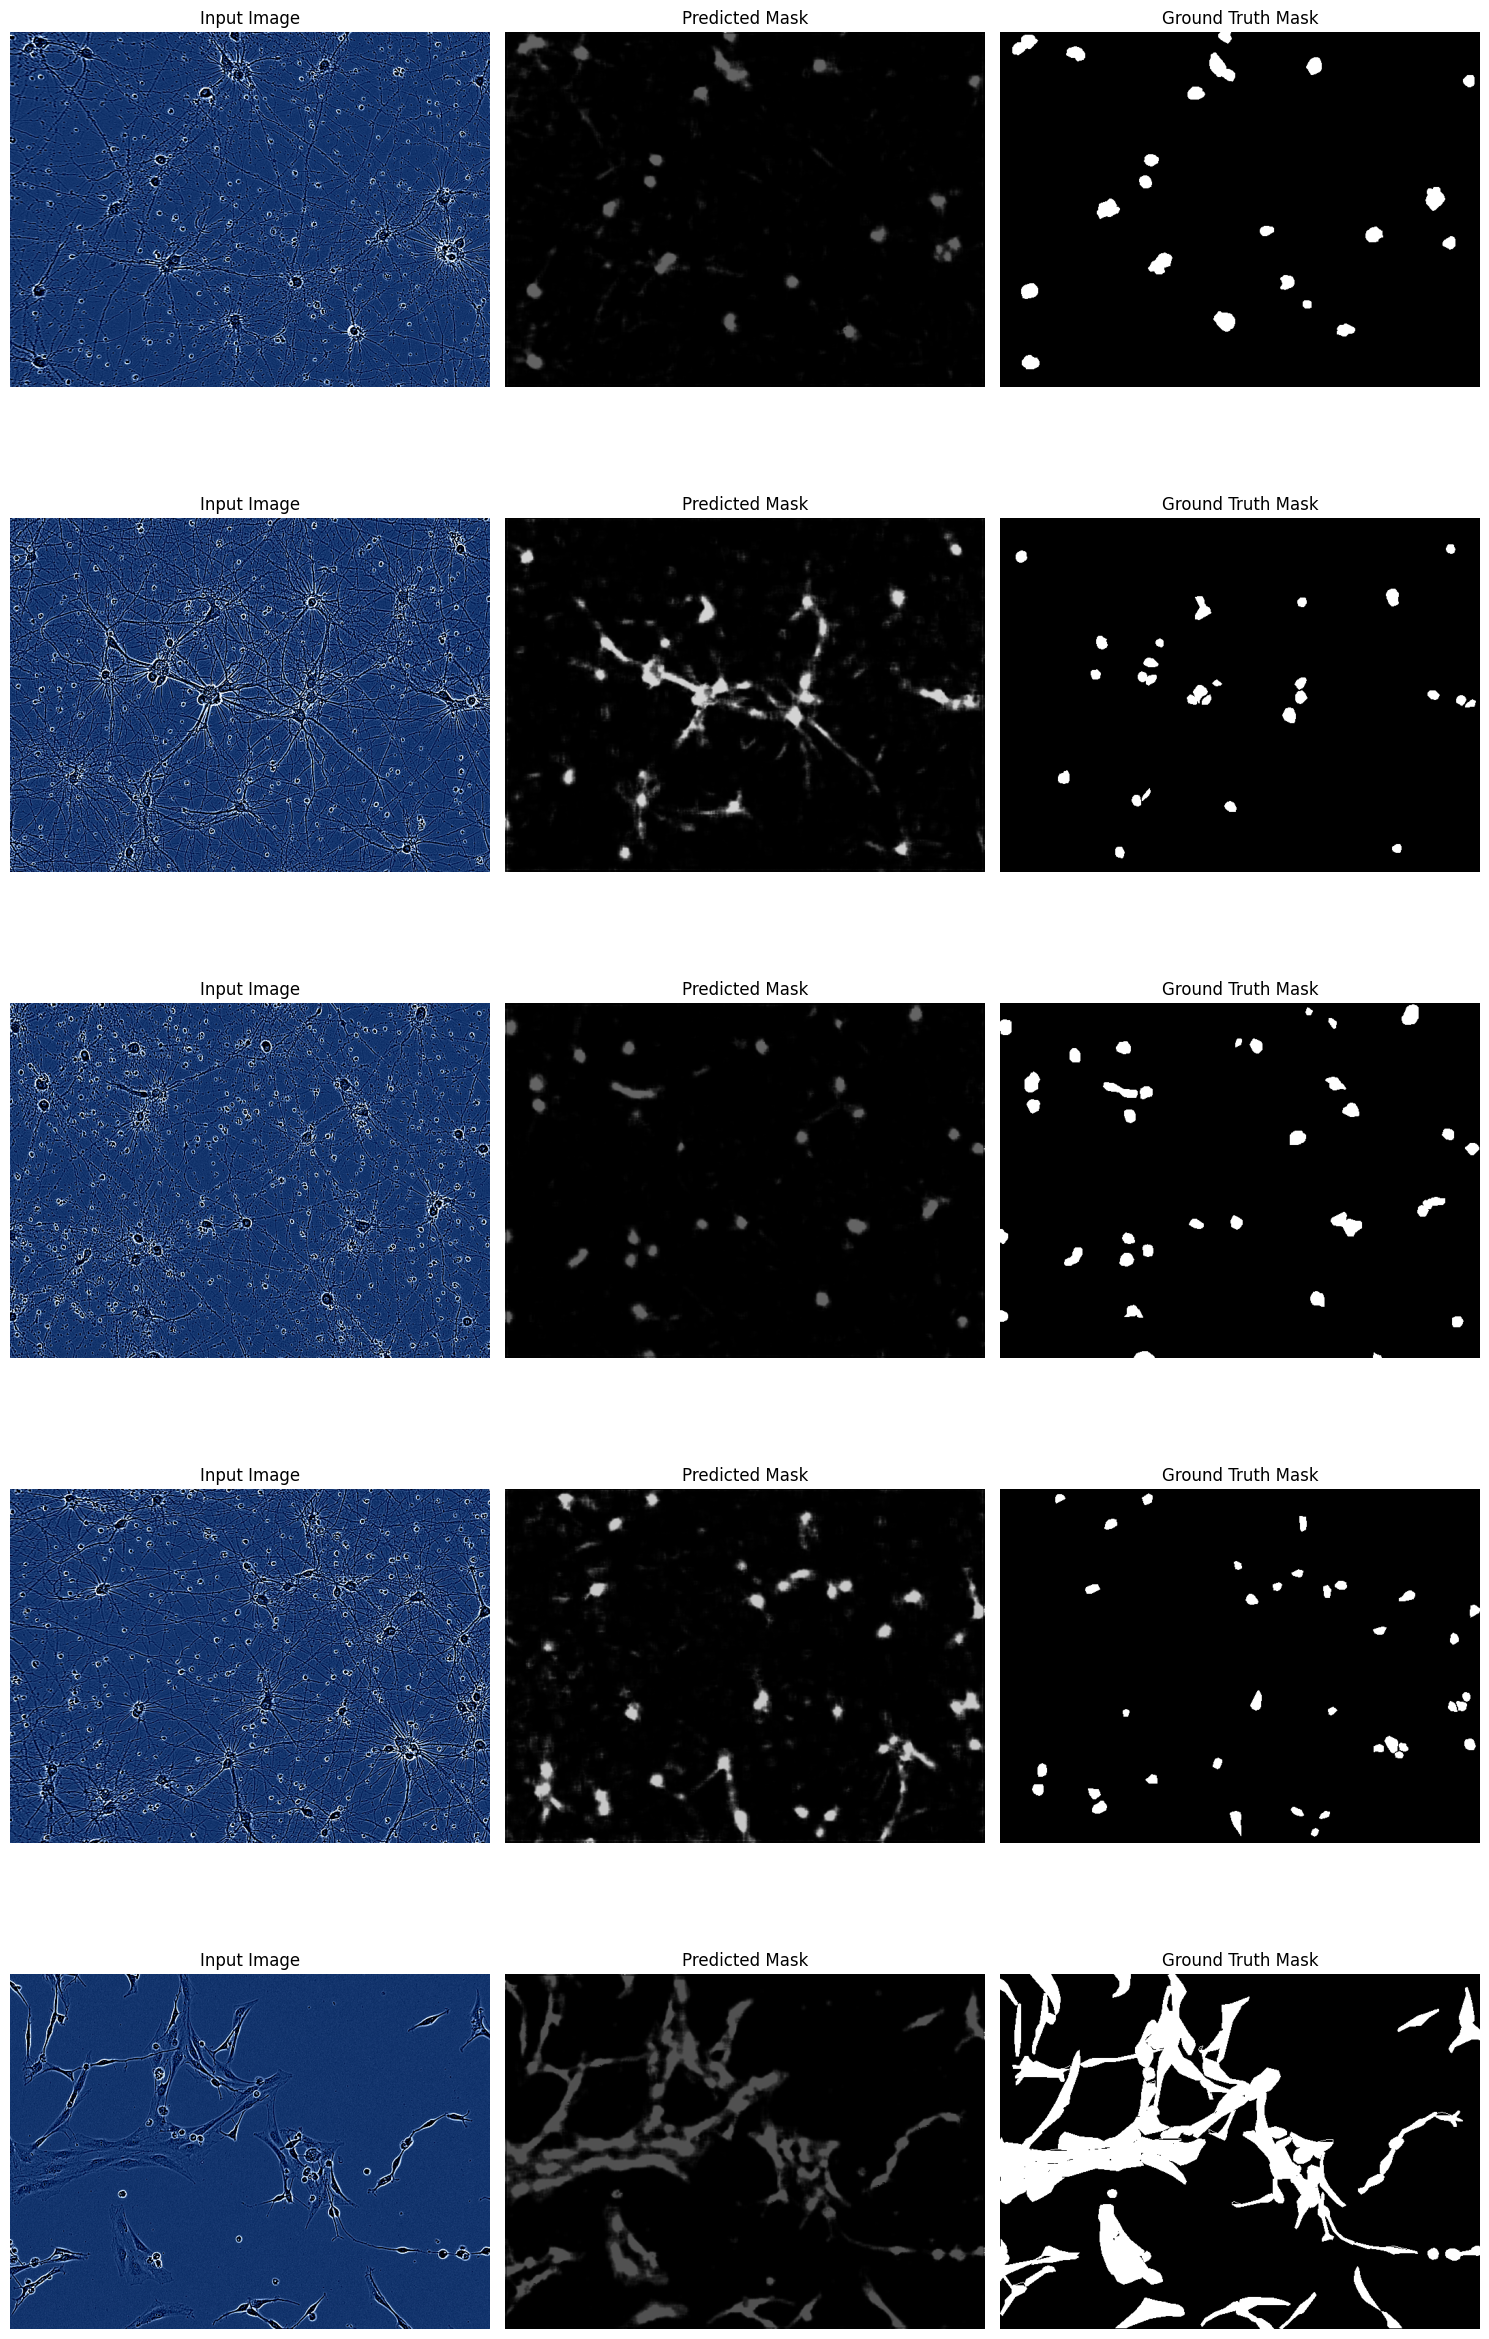

In [12]:
# Example visualization using matplotlib
import matplotlib.pyplot as plt
import random
num_val_samples = val_size
# Define the number of images to visualize
num_images_to_visualize = 5  # You can adjust this as needed

# Choose random sample indices within the bounds of the validation dataset
sample_indices = random.sample(range(num_val_samples), num_images_to_visualize)

# Plot each image along with its predicted mask and ground truth mask
plt.figure(figsize=(15, 5*num_images_to_visualize))
for i, sample_index in enumerate(sample_indices):
    plt.subplot(num_images_to_visualize, 3, i*3 + 1)
    plt.imshow(input_images[sample_index].transpose(1, 2, 0))  # Assuming images are in CHW format
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(num_images_to_visualize, 3, i*3 + 2)
    plt.imshow(predicted_masks[sample_index][0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(num_images_to_visualize, 3, i*3 + 3)
    plt.imshow(gt_masks[sample_index][0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


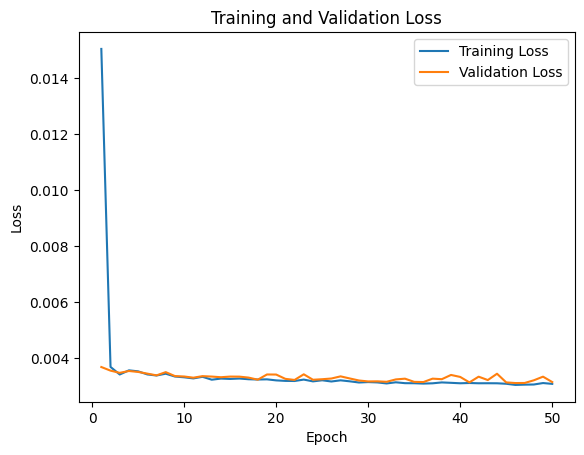

In [13]:
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#torch.save(model.state_dict(), '/content/drive/MyDrive/ML_Project/kaku_model.pth')

(520, 704)


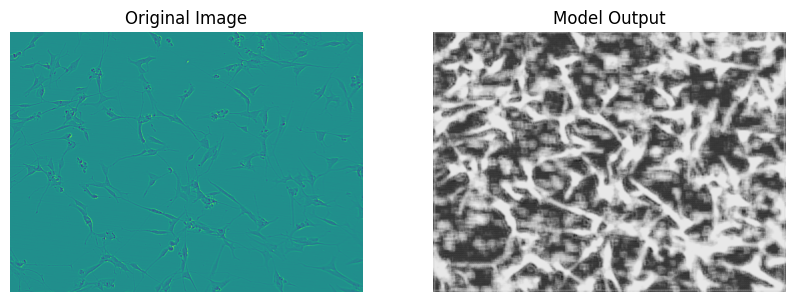

(520, 704)


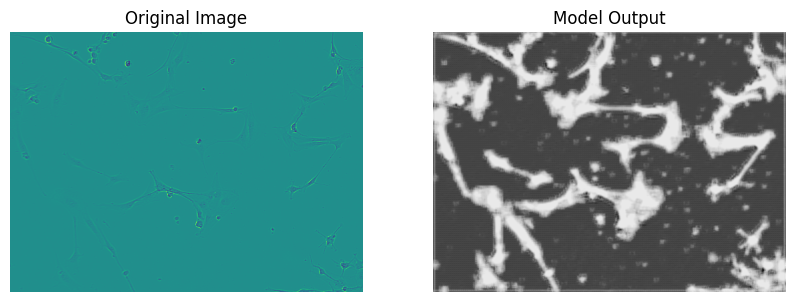

(520, 704)


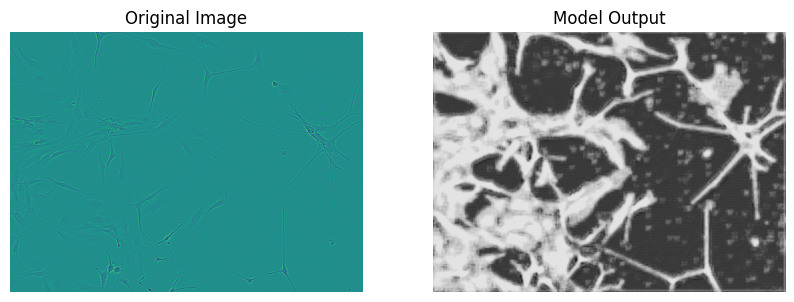

In [14]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)
    return image

test_path = '/content/drive/MyDrive/ML_Project/sartorius-cell-instance-segmentation/test'
test_images = ['7ae19de7bc2a.png', 'd48ec7815252.png', 'd8bfd1dafdc4.png']

for test_image in test_images:
  input_image = preprocess_image(test_path + '/' + test_image)
  input_image = input_image.to(device)


  model = SmallUNet()
  model_path = '/content/drive/MyDrive/ML_Project/model.pth'
  model.load_state_dict(torch.load(model_path))
  model.eval()
  model.to(device)

  with torch.no_grad():
      output = model(input_image)

  output_array = output.squeeze().cpu().numpy()
  print(output_array.shape)
  original_image = Image.open(test_path + '/' + test_image)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(original_image)
  axes[0].set_title('Original Image')
  axes[0].axis('off')
  axes[1].imshow(output_array, cmap='gray')
  axes[1].set_title('Model Output')
  axes[1].axis('off')
  plt.show()





Evaluation

In [15]:
# model.eval()  # Set the model to evaluation mode
# val_loss = 0.0

# # Create empty lists to store predicted masks and ground truth masks
# predicted_masks = []
# gt_masks = []
# input_images = []

# with torch.no_grad():  # Disable gradient calculation for validation
#     for images, masks in val_loader:
#         # Move data to the appropriate device
#         images, masks = images.to(device), masks.to(device)

#         # Forward pass
#         outputs = model(images)

#         # Calculate loss
#         loss = criterion(outputs, masks)

#         # Accumulate validation loss
#         val_loss += loss.item()

#         # Convert outputs to probabilities and append to predicted masks list
#         predicted_masks.append(torch.sigmoid(outputs).cpu().detach().numpy())

#         # Append ground truth masks to gt_masks list
#         gt_masks.append(masks.cpu().detach().numpy())

#         input_images.append(images.cpu().detach().numpy())

# # Compute average validation loss
# avg_val_loss = val_loss / len(val_loader)
# print(f"Validation Loss: {avg_val_loss}")

# # Convert predicted_masks and gt_masks lists to numpy arrays
# predicted_masks = np.concatenate(predicted_masks)
# gt_masks = np.concatenate(gt_masks)
# input_images = np.concatenate(input_images)

# print(gt_masks.shape)
# print(predicted_masks.shape)
# print(input_images.shape)

In [16]:
import torch
import numpy as np

model.eval()
val_loss = 0.0

predicted_masks = []
gt_masks = []
input_images = []

threshold = 0.1

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)

        loss = criterion(outputs, masks)

        val_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()

        normalized_array = (probs - np.min(probs)) / (np.max(probs) - np.min(probs))

        predicted_masks.append(normalized_array)

        gt_masks.append(masks.cpu().detach().numpy())

        input_images.append(images.cpu().detach().numpy())

avg_val_loss = val_loss / len(val_loader)
print(f"Validation Loss: {avg_val_loss}")

predicted_masks = np.concatenate(predicted_masks, axis=0)
gt_masks = np.concatenate(gt_masks, axis=0)
input_images = np.concatenate(input_images, axis=0)

print(gt_masks.shape)
print(predicted_masks.shape)
print(input_images.shape)



Validation Loss: 0.003109432264075925
(60, 1, 520, 704)
(60, 1, 520, 704)
(60, 3, 520, 704)


9819481
(60, 1, 520, 704)


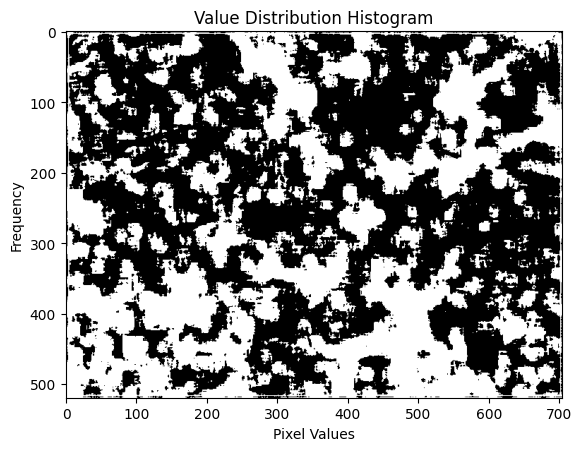

In [17]:
thresh = 0.005
num_vals = np.sum(predicted_masks > thresh)
print(num_vals)

thresholded_probs = predicted_masks > thresh
print(thresholded_probs.shape)

# # Plot the histogram
plt.imshow(thresholded_probs[30][0], cmap='gray')

# Add titles and labels
plt.title('Value Distribution Histogram')
plt.xlabel('Pixel Values')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [18]:
def calculate_true_positives(predicted_mask, gt_mask, iou_threshold):
    intersection = np.logical_and(predicted_mask, gt_mask)

    intersection_area = np.sum(intersection)
    union_area = np.sum(np.logical_or(predicted_mask, gt_mask))
    iou = intersection_area / union_area

    if iou > iou_threshold:
        return 1
    else:
        return 0


def calculate_false_positives(predicted_mask, gt_mask, iou_threshold):
    intersection = np.logical_and(predicted_mask, gt_mask)

    intersection_area = np.sum(intersection)
    union_area = np.sum(np.logical_or(predicted_mask, gt_mask))
    iou = intersection_area / union_area

    if iou <= iou_threshold:
        return 1
    else:
        return 0


def calculate_false_negatives(predicted_mask, gt_mask, iou_threshold):
    intersection = np.logical_and(predicted_mask, gt_mask)

    intersection_area = np.sum(intersection)
    union_area = np.sum(np.logical_or(predicted_mask, gt_mask))
    iou = intersection_area / union_area

    if iou <= iou_threshold:
        return 1
    else:
        return 0


iou_thresholds = np.arange(0.5, 1.0, 0.05)

total_tp = {iou: 0 for iou in iou_thresholds}
total_fp = {iou: 0 for iou in iou_thresholds}
total_fn = {iou: 0 for iou in iou_thresholds}

for gt, pred in zip(gt_masks, thresholded_probs):
    for iou in iou_thresholds:
        tp = calculate_true_positives(pred, gt, iou)
        fp = calculate_false_positives(pred, gt, iou)
        fn = calculate_false_negatives(pred, gt, iou)

        total_tp[iou] += tp
        total_fp[iou] += fp
        total_fn[iou] += fn

precision = {iou: total_tp[iou] / (total_tp[iou] + total_fp[iou] + total_fn[iou]) for iou in iou_thresholds}

average_precision_per_image = {iou: precision[iou] / len(iou_thresholds) for iou in iou_thresholds}

mAP = np.mean(list(average_precision_per_image.values()))

In [21]:
print(f"Final avg precision per image: \n")
for key, value in average_precision_per_image.items():
    print(f"{key}: {value}\n")
print(f"Final mean average precision: {mAP}")

Final avg precision per image: 

0.5: 0.006194690265486726

0.55: 0.006194690265486726

0.6000000000000001: 0.0034482758620689655

0.6500000000000001: 0.001694915254237288

0.7000000000000002: 0.0

0.7500000000000002: 0.0

0.8000000000000003: 0.0

0.8500000000000003: 0.0

0.9000000000000004: 0.0

0.9500000000000004: 0.0

Final mean average precision: 0.0017532571647279707
